<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Hello World

This notebook serves as an introduction to using Instill AI's core services via our [Python SDK](https://www.instill.tech/docs/sdk/python). We will demonstrate how to perform model inferences with [**Instill Model**](https://www.instill.tech/docs/model/introduction), how to create and run your own pipelines with [**Instill VDP**](https://www.instill.tech/docs/vdp/introduction), and how to create your own unstructured data catalog with [**Instill Artifact**](https://www.instill.tech/docs/artifact/introduction).

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [1]:
!pip install instill-sdk==0.15.0 --quiet

In [ ]:
from instill.clients import init_core_client

core = init_core_client(api_token="YOUR_INSTILL_API_TOKEN")

### ⚗️ **Instill Model**

**Instill Model** is an advanced MLOps/LLMOps platform and a key component of
the **Instill Core** suite, designed to address the challenges of developing and
deploying deep learning models for unstructured data ETL. It provides robust
model serving, orchestration and monitoring capabilities, enabling efficient
management and deployment of machine learning models.

Here we will perform a model inference using the [YOLOv7
model](https://instill.tech/instill-ai/models/yolov7/playground?version=v0.1.0)
served with **Instill Model** on the **Instill Cloud** platform. We will use
this model to perform object detection on an
[image](https://artifacts.instill.tech/imgs/bear.jpg) of a bear.

First, let's load the image.

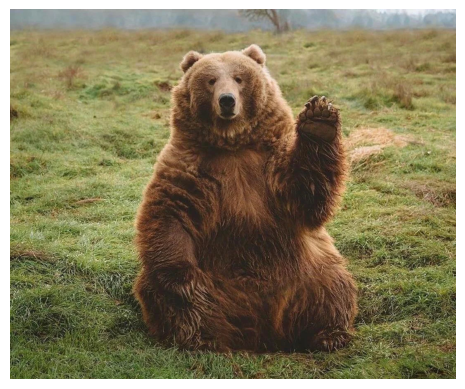

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

url = "https://artifacts.instill.tech/imgs/bear.jpg"

response = requests.get(url)

img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis('off')
plt.show()

Hello bear! 🐻👋

Great, now we can initialize our Model client, and trigger the model inference by passing in the data as an `image-url`.

In [23]:
model = core.model

In [6]:
model_response = model.trigger(
    namespace_id="instill-ai",
    model_id="yolov7",
    version="v0.1.0",
    task_inputs=[
        {
            "data": {
                "image-url": "https://artifacts.instill.tech/imgs/bear.jpg",
                "type": "image-url",
            }
        }
    ]
)

In [7]:
print(model_response)

task: TASK_DETECTION
task_outputs {
  fields {
    key: "data"
    value {
      struct_value {
        fields {
          key: "objects"
          value {
            list_value {
              values {
                struct_value {
                  fields {
                    key: "score"
                    value {
                      number_value: 0.96603703498840332
                    }
                  }
                  fields {
                    key: "category"
                    value {
                      string_value: "bear"
                    }
                  }
                  fields {
                    key: "bounding-box"
                    value {
                      struct_value {
                        fields {
                          key: "width"
                          value {
                            number_value: 554
                          }
                        }
                        fields {
                          key: "

The predicted score, category and bounding box have been returned in the
`model_response` object.

As part of the full-stack AI solution offered by **Instill Core**, **Instill
Model** works in conjunction with **Instill VDP** and **Instill Artifact**. This
means that **Instill Model** can be used as either a standalone scalable and
robust model serving solution, or in tandem with **Instill VDP** to leverage
your own custom models and create bespoke AI workflows.

Now let's take a look at building an AI pipeline with **Instill VDP**.

### 💧 **Instill VDP** (Versatile Data Pipeline)

**Instill VDP** is a powerful tool designed to build
end-to-end unstructured data pipelines. It leverages the capabilities of
3rd-party data, AI, and applications functionalities and seamlessly connect with
**Instill Model** and **Instill Artifact** via **Instill Component** components.

We will now build on the previous section by creating a pipeline that connects
to the same YOLOv7 model served with **Instill Model**, and uses the model
response object to annotate the input image using our [Image
Operator](https://www.instill.tech/docs/component/operator/image).

Let's first initialize the Pipeline client:

In [24]:
pipeline = core.pipeline

VDP pipelines are created by writing YAML recipes. All recipes have three key elements:

1. **variable** - where you define the inputs to the pipeline.
2. **component** - this section consists of AI, data, application, or operator components that can manipulate the input variables, or connect to other external data sources.
3. **output** - the outputs of the pipeline.

The pipeline recipe essentially defines a directed acyclic graph and is a powerful means to record the data lineage for complex ETL workflows. Learn more in our [documentation](https://www.instill.tech/docs/vdp/pipeline-recipe)!

We will now define a simple computer vision pipeline for object detection:

In [ ]:
yaml_recipe = """
version: v1beta

variable:
  input:
    title: Input
    description: Upload the Image
    instill-format: image

component:
  yolov7:
    type: instill-model
    input:
      model-name: instill-ai/yolov7/v0.1.0
      image-base64: ${variable.input}
    task: TASK_DETECTION
  annotate-image:
    type: image
    input:
      show-score: true
      objects: ${yolov7.output.objects}
      image: ${variable.input}
    task: TASK_DRAW_DETECTION

output:
  annotated-image:
    title: Annotated Image
    value: ${annotate-image.output.image}
"""

Note that the `${xxx}` syntax is used to reference variables or component outputs.

We can now create our pipeline on **Instill Cloud**:

In [ ]:
namespace_id = "YOUR_INSTILL_NAMESPACE_ID"

create_response = pipeline.create_pipeline(
    namespace_id=namespace_id,
    pipeline_id="object-detection",
    description="Uses the YOLOv7 model to perform object detection and annotates the image with the bounding box and classification result.",
    raw_recipe=yaml_recipe,
)

Let's now run this pipeline on the same image as before. Note that we first need to base64 encode the image before passing it to the pipeline.

In [ ]:
import base64
base64_image = base64.b64encode(response.content).decode('utf-8')

pipeline_response = pipeline.trigger(
    namespace_id=namespace_id,
    pipeline_id="object-detection",
    data=[{"input": base64_image}],
)

To view the resultant annotated image, we just need to extract and decode the image from the pipeline response:

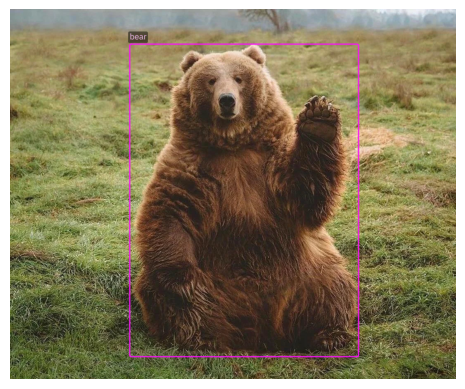

In [ ]:
from google.protobuf.json_format import MessageToDict

data = MessageToDict(pipeline_response)
output_base64_image = data['outputs'][0]['annotated-image'].split(',')[1]

# Decode the base64 image, then decoded the bytes into an image
image = Image.open(BytesIO(base64.b64decode(output_base64_image)))

plt.imshow(image)
plt.axis('off')
plt.show()

Yep, it's definitely a bear! 🐻

### 💾 **Instill Artifact**

Instill Artifact orchestrates unstructured data to transform documents (e.g., HTML, PDF, CSV, PPTX, DOC), images (e.g., JPG, PNG, TIFF), audio (e.g., WAV, MP3 ) and video (e.g., MP4, MOV) into Instill Catalog - a unified AI-ready format. Instill Catalog is more than just a Knowledge Base; it is an Augmented Data Catalog for unstructured data and AI that ensures your data is clean, curated, and prepared for all of your future AI and Retrieval-Augmented Generation (RAG) needs.

Let's learn something about brown bears 🐻 and make a process [this](http://www.bearconservation.org.uk/Factsheet%202%20Brown%20Bear%2020140909.pdf) PDF document into an Instill Catalog.

We will begin by initializing the Artifact client and create an empty Catalog called `brown_bears`.

In [15]:
artifact = core.artifact

In [16]:
catalog_id = "brown_bears"

artifact.create_catalog(
    namespace_id=namespace_id,
    name=catalog_id,
    description="Brown bear facts",
    tags=["bear", "conservation"],
)

catalog {
  catalog_id: "brown_bears"
  name: "brown_bears"
  description: "Brown bear facts"
  create_time: "2024-11-01 12:20:58.38601 +0000 UTC"
  update_time: "2024-11-01 12:20:58.388403349 +0000 UTC"
  owner_name: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  tags: "bear"
  tags: "conservation"
  converting_pipelines: "preset/indexing-convert-pdf"
  splitting_pipelines: "preset/indexing-split-text"
  splitting_pipelines: "preset/indexing-split-markdown"
  embedding_pipelines: "preset/indexing-embed"
}

We will now obtain and save the PDF document to our working directory.

In [17]:
brown_bears = "http://www.bearconservation.org.uk/Factsheet%202%20Brown%20Bear%2020140909.pdf"

response = requests.get(brown_bears)

with open("Brown_bear_factsheet.pdf", "wb") as file:
    file.write(response.content)

Now we can [upload](https://www.instill.tech/docs/artifact/upload-files) the file to the catalog and [process](https://www.instill.tech/docs/artifact/process-files) it. Under the hood, the file is converted into high-quality Markdown-formatted text, split into smaller chunks, and converted into embedding vectors which are stored in a vector database for efficient search and retrieval.

In [18]:
upload_response = artifact.upload_catalog_file(
    namespace_id=namespace_id,
    catalog_id=catalog_id,
    file_path="Brown_bear_factsheet.pdf",
)

artifact.process_catalog_files(file_uids=[upload_response.file.file_uid])

files {
  file_uid: "6d5b3279-87b5-4985-bfa6-a92d8e71ce8e"
  name: "Brown_bear_factsheet.pdf"
  type: FILE_TYPE_PDF
  process_status: FILE_PROCESS_STATUS_WAITING
  owner_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  creator_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  catalog_uid: "13c72237-bf35-4b86-8ead-ed2816bbdf5e"
  create_time {
    seconds: 1730463661
    nanos: 241355000
  }
  update_time {
    seconds: 1730463661
    nanos: 427816000
  }
}

We can observe the status of the files processing by checking `process_status` with the [List Files](https://www.instill.tech/docs/artifact/file#list-files-via-api) API:

In [20]:
artifact.list_catalog_files(namespace_id=namespace_id, catalog_id=catalog_id)

files {
  file_uid: "6d5b3279-87b5-4985-bfa6-a92d8e71ce8e"
  name: "Brown_bear_factsheet.pdf"
  type: FILE_TYPE_PDF
  process_status: FILE_PROCESS_STATUS_COMPLETED
  owner_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  creator_uid: "a7219ce0-4c6c-4dd5-8ac5-1fbf87aedd4a"
  catalog_uid: "13c72237-bf35-4b86-8ead-ed2816bbdf5e"
  create_time {
    seconds: 1730463661
    nanos: 241355000
  }
  update_time {
    seconds: 1730463688
    nanos: 945594000
  }
  size: 1090491
  total_chunks: 95
  total_tokens: 8229
}
total_size: 1
filter {
}

Once `process_status` is equal to `FILE_PROCESS_STATUS_COMPLETED`, you can [Retrieve](https://www.instill.tech/docs/artifact/retrieve) from the catalog and also use the [Ask Catalog](https://www.instill.tech/docs/artifact/ask) API:

In [21]:
artifact.question_answering(
    namespace_id=namespace_id,
    catalog_id=catalog_id,
    question="What do brown bears like to eat?",
    top_k=5,
)

answer: "Brown bears like to eat grasses, sedges, forbs, nuts, berries, fruits, roots, tubers, bulbs, small mammals, reptiles, honey, insects, and fish, notably salmon."
similar_chunks {
  chunk_uid: "22802980-d8f0-44eb-9b0e-6c4a30a3d967"
  similarity_score: 0.710455954
  text_content: "# Species Factsheet 2: Brown bear (Ursus arctos)\n\ncomponents of some brown bear population’s diets and seem likely to become increasingly\nsusceptible to the changing climate. In the short to medium term the best way to ameliorate\nthese effects is to restore and protect existing habitat and to create corridors between areas\nof habitat. In the longer term it is to be hoped that the effects of climate change can be\nhalted and, ultimately, reversed."
  source_file: "Brown_bear_factsheet.pdf"
}
similar_chunks {
  chunk_uid: "8d093e1f-63e8-4c3b-9097-196e66fae228"
  similarity_score: 0.687832832
  text_content: "# Species Factsheet 2: Brown bear (Ursus arctos)\n\nDIET\nBrown bears are truly omnivorous wi

In [22]:
model.close()
pipeline.close()
artifact.close()

Hope you enjoyed this introductory notebook!

Checkout our [blog](https://www.instill.tech/blog) for more tutorials and AI-related insights 🔮, and stay tuned for more notebooks coming soon! 🚀